# Quick Start

## Introduction
In this tutorial, you will get a quick view of `AiiDA-WorkGraph`. To run this tutorial, you need to install `aiida-workgraph`. Open a terminal and run:

```console
pip install aiida-workgraph
```

Start (or restart) the AiiDA daemon if needed:
```console
verdi daemon start
```

Load the AiiDA profile.

In [1]:
from aiida import load_profile
load_profile()

Profile<uuid='bcf9e395e4bf4b64a0a705d8659c0a9c' name='default'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`.


### Create task
Task is the basic building block of the WorkGraph. A task has inputs, outputs. In AiiDA, one uses the `calcfunction` to do the calculation and generate new data. AiiDA-WorkGraph goes one step further by transforming a `calcfunction` to a `Task`.

In [2]:
from aiida_workgraph import task

# define add task
@task.calcfunction()
def add(x, y):
    return x + y

# define multiply task
@task.calcfunction()
def multiply(x, y):
    return x*y



#### Visualize the task
If you are running in a Jupiter notebook, you can visualize the task directly. You can also export the task to html file so that it can be visualized in a browser.

In [3]:

# export the task to html file so that it can be visualized in a browser
add.task().to_html()

# comment out the following line to visualize the task in Jupyter Notebook
# add.task()

The input sockets are generated automatically based on the function arguments. The default name of the output socket is `result`. There are also some built-in sockets, like `_wait` and `_outputs`.  In case of `calcfunction`, it also has several built-in sockets, such as `metadata`. One can also create a task instance and inpsect its inputs and outputs:

In [4]:
add1 = add.task()
print("Inputs:", add1.inputs.keys())
print("Outputs:", add1.outputs.keys())

Inputs: ['metadata', 'metadata.store_provenance', 'metadata.description', 'metadata.label', 'metadata.call_link_label', 'x', 'y', '_wait']
Outputs: ['result', '_outputs', '_wait']


### Create the workflow
Three steps:

- create a empty `WorkGraph`
- add tasks: `add` and `multiply`.
- link the output of the `add` task to the `x` input of the `multiply` task.


In [5]:
from aiida_workgraph import WorkGraph

wg = WorkGraph("add_multiply_workflow")
add_task = wg.tasks.new(add, name="add1")
# link the output of the `add` task to one of the `x` input of the `multiply` task.
wg.tasks.new(multiply, name="multiply1", x = add_task.outputs["result"])

# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
# wg

### Submit and view results


In [6]:
from aiida.orm import Int

#------------------------- Submit the calculation -------------------
wg.submit(inputs = {"add1": {"x": Int(2),
                             "y": Int(3)
                             },
                    "multiply1": {"y": Int(4)}
                    },
          wait=True)

print("State of WorkGraph:   {}".format(wg.state))
print('Result of add      : {}'.format(wg.tasks["add1"].outputs[0].value))
print('Result of multiply : {}'.format(wg.tasks["multiply1"].outputs[0].value))

WorkGraph process created, PK: 22028
State of WorkGraph:   FINISHED
Result of add      : uuid: c649e840-becc-4631-8391-ba44042ed6ec (pk: 22030) value: 5
Result of multiply : uuid: a586f00b-c7d0-4f64-ab0d-3a0cbd8cf9e0 (pk: 22032) value: 20


One can also generate the node graph from the AiiDA process:

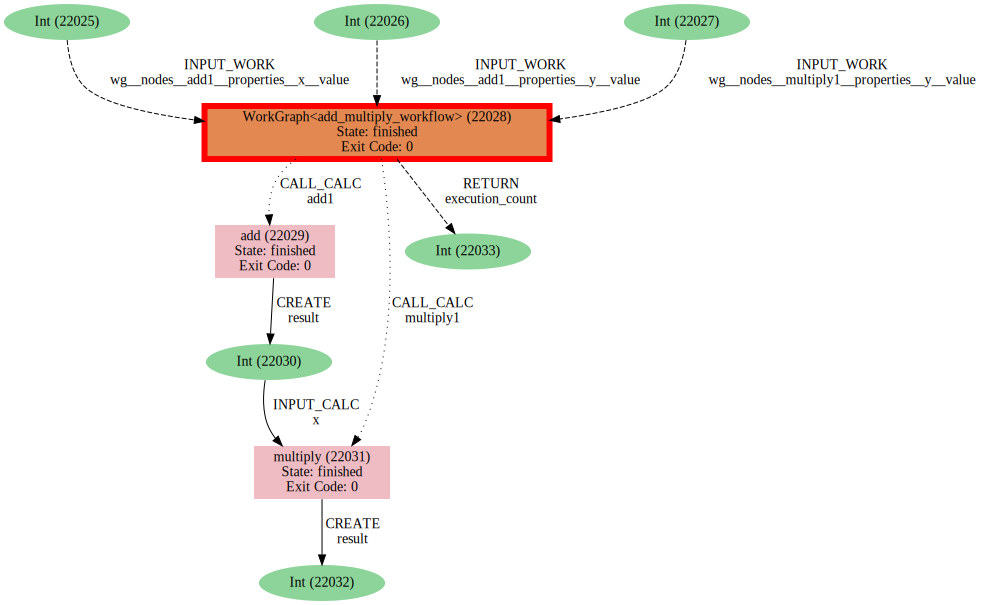

In [7]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Remote job
We set `run_remotely` to `True` when adding the task. This will tell the engine that the job should be run on a remote computer.

In this case, we use define the task using normal function instead of `calcfunction`. Thus, user does not need to install AiiDA on the remote computer.


In [8]:
from aiida_workgraph import WorkGraph, task

# define add task
@task()
def add(x, y):
    return x + y

# define multiply task
@task()
def multiply(x, y):
    return x*y

wg = WorkGraph("second_workflow")
wg.tasks.new(add, name="add", run_remotely=True)
wg.tasks.new(multiply, name="multiply", x=wg.tasks["add"].outputs[0], run_remotely=True)

# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# visualize the workgraph in jupyter-notebook
# wg


### Submit the workgraph

**Code**: We can set the `computer` to the remote computer where we want to run the job. This will create a code `python3@computer` if not exists. Of course, you can also set the `code` directly if you have already created the code.


**Data**: Users can (and is recoomaneded) use normal Python data as input. The workgraph will transfer the data to AiiDA data (`GeneralData`) using pickle.

**Python Version**: since pickle is used to store and load data, the Python version on the remote computer should match the one used in the localhost. One can use conda to create a virtual environment with the same Python version. Then activate the environment before running the script.

```python
# For real applications, one can pass metadata to the scheduler to activate the conda environment
metadata = {
    "options": {
        'custom_scheduler_commands' : 'module load anaconda\nconda activate py3.11\n',
    }
}
```

WorkGraph process created, PK: 22037

Result of multiply is uuid: 0873da89-625a-4874-8b7b-172b8a675db4 (pk: 22053) value: 20 




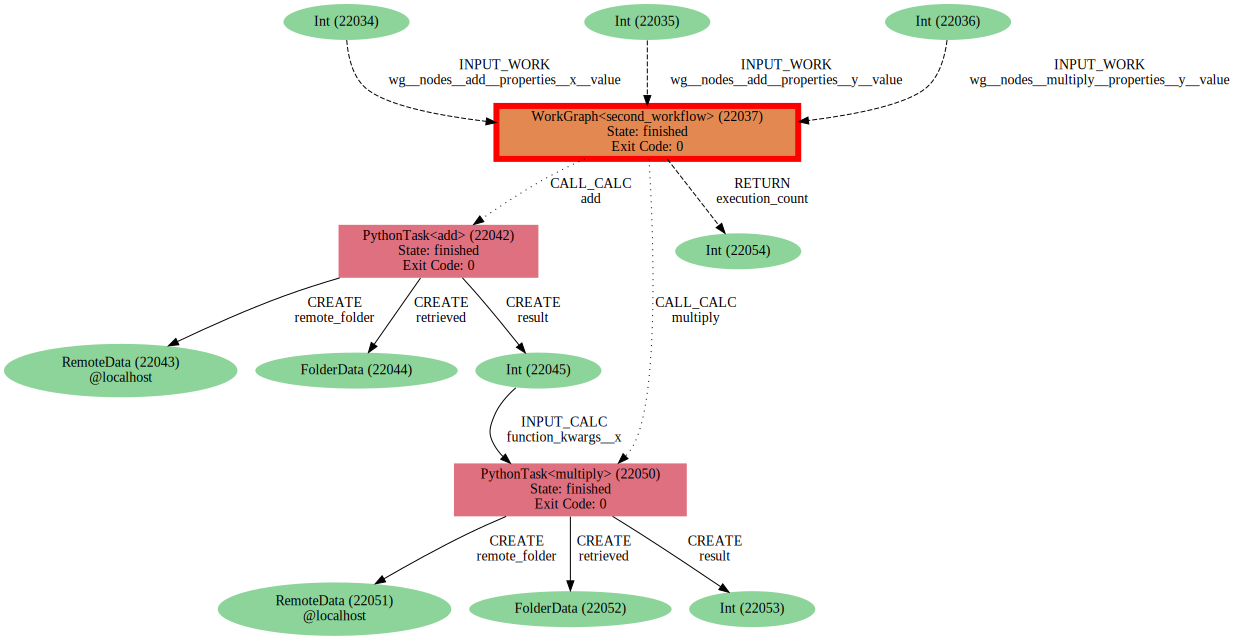

In [9]:
from aiida_workgraph.utils import generate_node_graph

#------------------------- Submit the calculation -------------------
# For real applications, one can pass metadata to the scheduler to activate the conda environment
metadata = {
    "options": {
        # 'custom_scheduler_commands' : 'module load anaconda\nconda activate py3.11\n',
        'custom_scheduler_commands' : '',
    }
}

wg.submit(inputs = {"add": {"x": 2, "y": 3,
                            "computer": "localhost",
                            "metadata": metadata},
                    "multiply": {"y": 4,
                                 "computer": "localhost",
                                 "metadata": metadata}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.tasks["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

### Use parent folder
The parent_folder parameter allows a task to access the output files of a parent task. This feature is particularly useful when you want to reuse data generated by a previous computation in subsequent computations. In the following example, the multiply task uses the `result.txt` file created by the add task.

By default, the content of the parent folder is symlinked to the working directory. In the function, you can access the parent folder using the relative path. For example, `./parent_folder/result.txt`.

In [10]:
from aiida_workgraph import WorkGraph, task

# define add task
@task()
def add(x, y):
    z = x + y
    with open("result.txt", "w") as f:
        f.write(str(z))

# define multiply task
@task()
def multiply(x, y):
    with open("parent_folder/result.txt", "r") as f:
        z = int(f.read())
    return x*y + z

wg = WorkGraph("third_workflow")
wg.tasks.new(add, name="add", run_remotely=True)
wg.tasks.new(multiply, name="multiply",
             parent_folder=wg.tasks["add"].outputs["remote_folder"],
             run_remotely=True,
             )

wg.to_html()


Submit the calculation

In [11]:
#------------------------- Submit the calculation -------------------
wg.submit(inputs = {"add": {"x": 2, "y": 3, "computer": "localhost"},
                    "multiply": {"x": 3, "y": 4, "computer": "localhost"}},
          wait=True)
print("\nResult of multiply is {} \n\n".format(wg.tasks["multiply"].outputs['result'].value))

WorkGraph process created, PK: 22059

Result of multiply is uuid: bd37522c-5520-429e-89c9-320be99c5063 (pk: 22075) value: 17 




## CalcJob and WorkChain
AiiDA also provide builtin `CalcJob` to run a calculation on a remote computer. AiiDA community also provides a lot of well-written `calcfunction` and `WorkChain`. One can use these AiiDA component direclty in the WorkGraph. The inputs and outputs of the task is automatically generated based on the input and output port of the AiiDA component.

Here is an example of using the `ArithmeticAddCalculation` Calcjob inside the workgraph.

In [12]:
from aiida_workgraph import WorkGraph
from aiida.calculations.arithmetic.add import ArithmeticAddCalculation
from aiida.orm import Int, load_code

code = load_code("add@localhost")

wg = WorkGraph("test_add_multiply")
add1 = wg.tasks.new(ArithmeticAddCalculation, name="add1", x=Int(2), y=Int(3), code=code)
add2 = wg.tasks.new(ArithmeticAddCalculation, name="add2", y=Int(3), code=code)
wg.links.new(wg.tasks["add1"].outputs["sum"], wg.tasks["add2"].inputs["x"])
wg.to_html()


Submit the workgraph and wait for the result.

In [13]:
wg.submit(wait=True)
print('Result of task add1: {}'.format(wg.tasks["add2"].outputs["sum"].value))

WorkGraph process created, PK: 22080
Result of task add1: uuid: 80ea98fd-ce08-43c7-a603-b9837edb4ee8 (pk: 22088) value: 8


/home/wang_x3/apps/miniconda3/envs/aiida/lib/python3.10/site-packages/aiida/orm/nodes/data/code/legacy.py:172: AiidaDeprecationWarning: `Code.get_description` method is deprecated, use the `description` property instead. (this will be removed in v3)
  warn_deprecation(


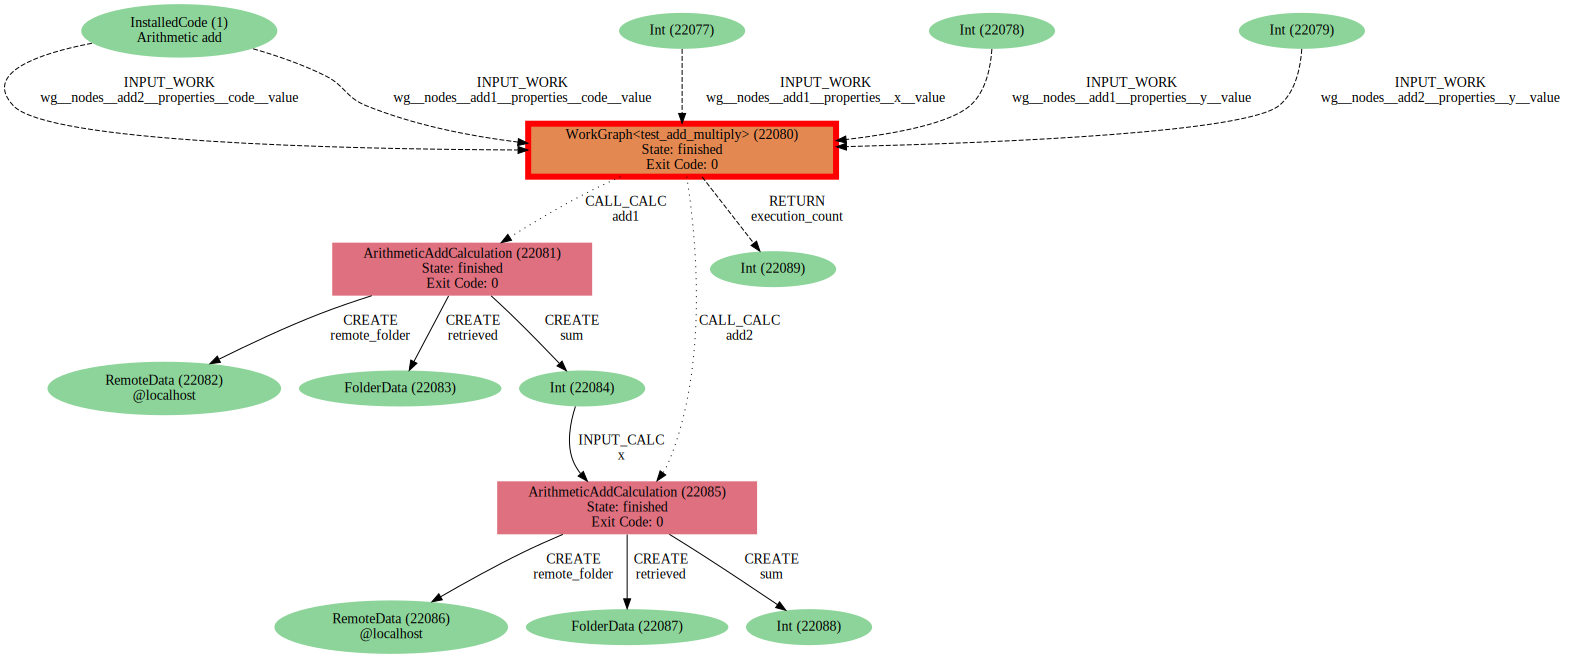

In [14]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg.pk)

## Graph builder
A `WorkGraph` is a group of tasks. One can treat a `WorkGraph` as a single task, and expose the inputs and outputs of the `WorkGraph`. This allow you to write:

- nested workflows
- dynamic workflow based on the input values. For example, if you want to use `if` and `for` to create the tasks, or repeat a calculation until it converges.

The `Graph Builder` allow user to create a dynamic workflow based on the input value, as well as nested workflows. Here is an example of nested workflow:

In [15]:
from aiida_workgraph import WorkGraph, task

# define add task
@task.calcfunction()
def add(x, y):
    return x + y

# define multiply task
@task.calcfunction()
def multiply(x, y):
    return x*y


# use task.graph_builder decorator, expose the output of "multiply" task
# as the output of the `WorkGraph`.
@task.graph_builder(outputs = [["multiply.result", "result"]])
def add_multiply(x, y, z):
    # Create a WorkGraph
    wg = WorkGraph()
    wg.tasks.new(add, name="add", x=x, y=y)
    wg.tasks.new(multiply, name="multiply", x=z)
    wg.links.new(wg.tasks["add"].outputs["result"], wg.tasks["multiply"].inputs["y"])
    # don't forget to return the `wg`
    return wg

Use this graph builder inside a `WorkGraph`:

In [16]:

from aiida_workgraph import WorkGraph
from aiida.orm import Int

wg = WorkGraph("test_graph_build")
# create a task using the graph builder
add_multiply1 = wg.tasks.new(add_multiply, x=Int(2), y=Int(3), z=Int(4))
add_multiply2 = wg.tasks.new(add_multiply, x=Int(2), y=Int(3))
# link the output of a task to the input of another task
wg.links.new(add_multiply1.outputs["result"], add_multiply2.inputs["z"])
wg.submit(wait=True)
print("Worktree state: ", wg.state)

WorkGraph process created, PK: 22095
Worktree state:  FINISHED


Get the result of the tasks:

In [17]:
print('Result of task add_multiply1: {}'.format(add_multiply1.outputs["result"].value))

Result of task add_multiply1: uuid: 4820db1e-6904-4d1c-a7b9-35b8d6dae016 (pk: 22100) value: 20


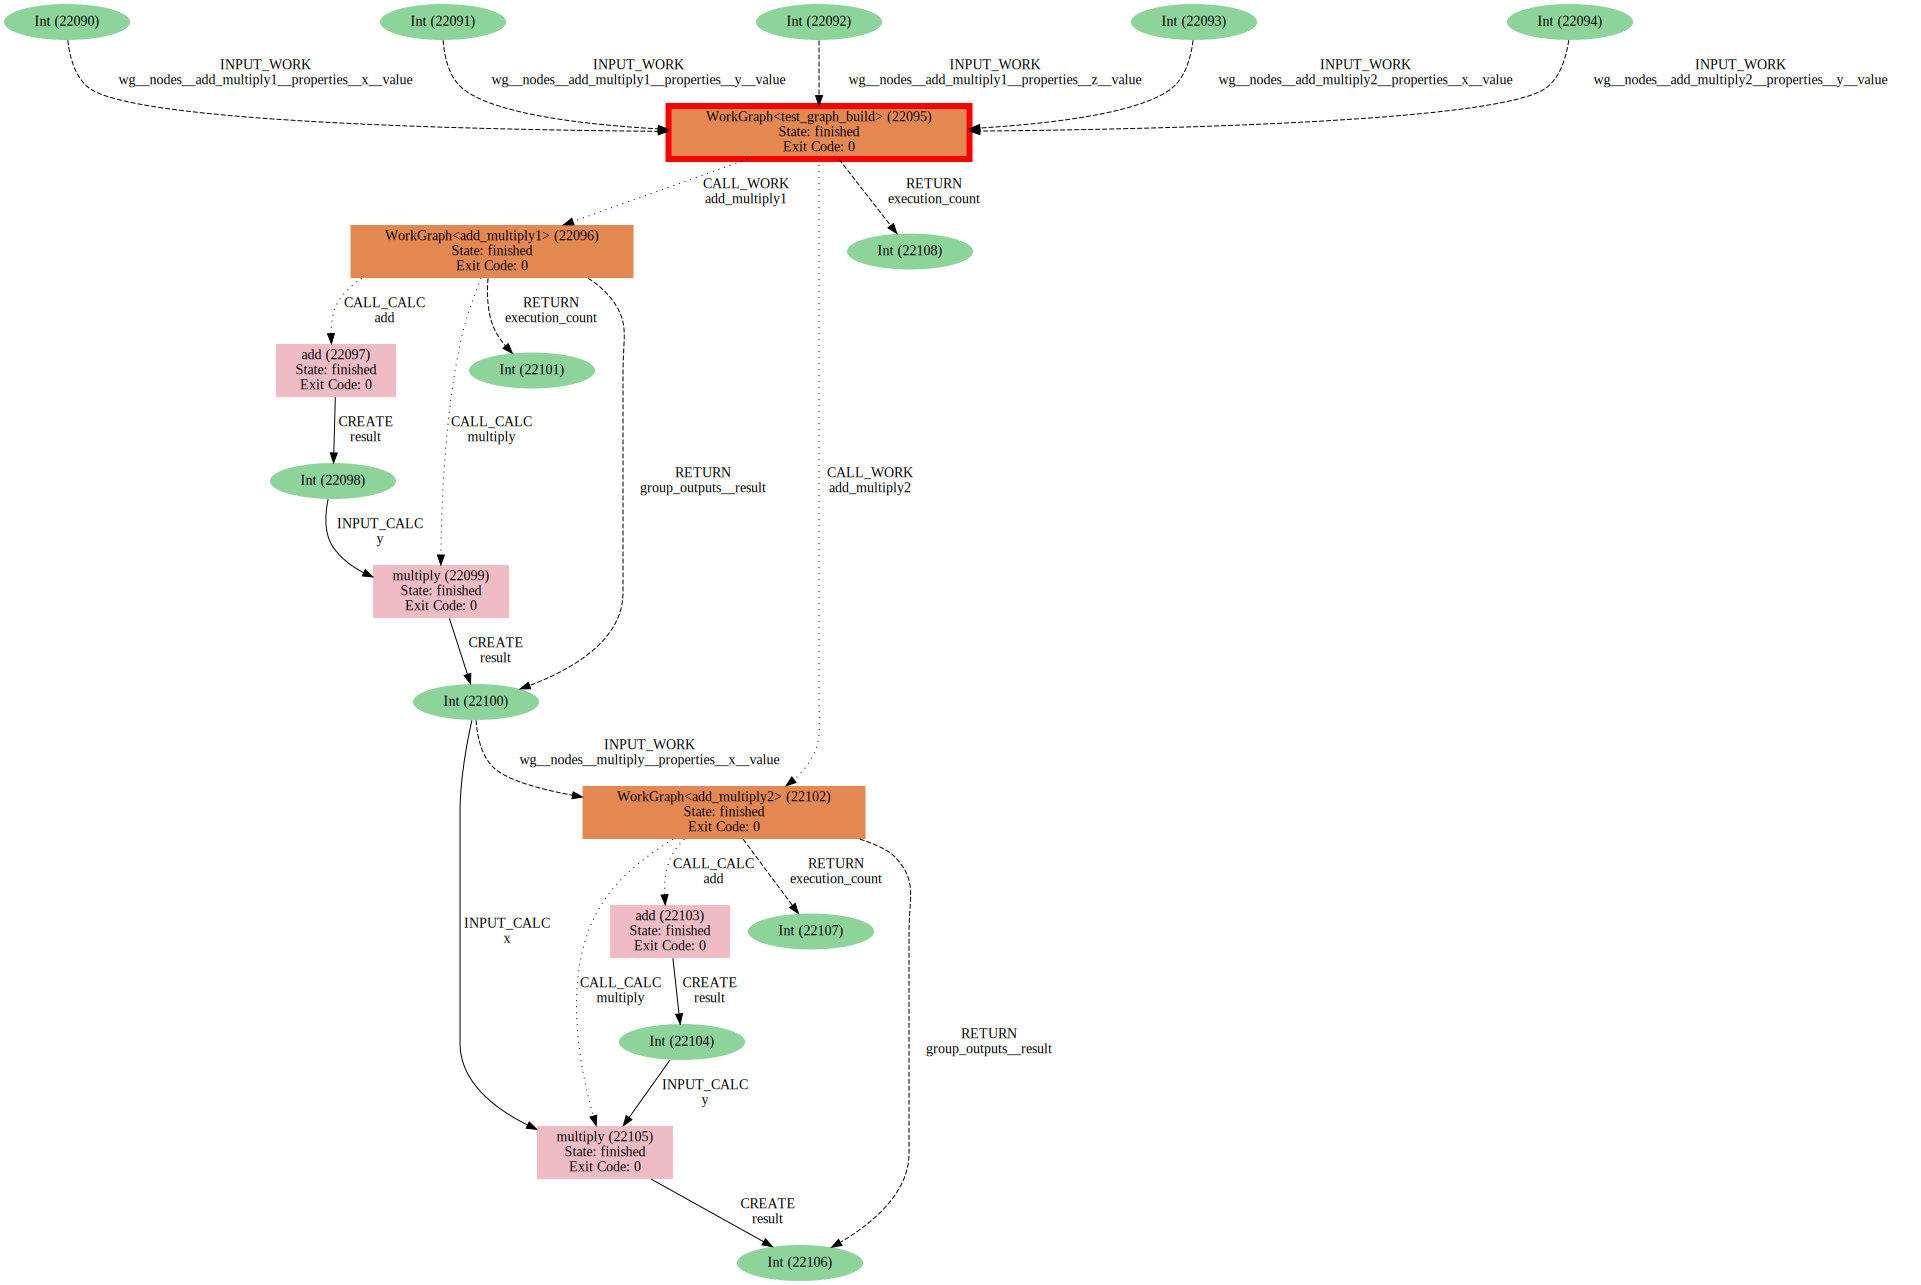

In [18]:
generate_node_graph(wg.pk)

### Start the web server
Worktree also provides a web GUI, where you can view and manage the workgraph. Open a terminal, and run:
```
workgraph web start
```
Then visit the page http://127.0.0.1:8000/workgraph, you can view the workgraph later from here. You should find all the submited workgraph, e.g., the `first_workflow` Worktree. Please click the pk and view the workgraph.

## What's Next

|        |                                         |
|---------------|----------------------------------------------------|
| [Concepts](concept/index.rst)                          | A brief introduction of WorkGraph’s main concepts.  |
| [Tutorials](tutorial/index.rst)                        | Real-world examples in computational materials science and more.                     |
| [HowTo](howto/index.rst)                              | Advanced topics and tips, e.g flow control using `if`, `for`, `while` and `context`.    |